In [1]:
import numpy  as np 
import pandas as pd  # Pandas is a data analysis library
import matplotlib.pyplot as plt # Matplotlib is a plotting library for the Python 
import nltk # NLTK is a leading platform for building Python programs to work with human language data.
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error
from nltk.tokenize.casual import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
np.random.seed(0)
nltk.download('all-nltk') 
from collections import defaultdict
import re



[nltk_data] Downloading collection 'all-nltk'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     

[nltk_data]    |   Package state_union is already up-to-date!
[nltk_data]    | Downloading package stopwords to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package stopwords is already up-to-date!
[nltk_data]    | Downloading package subjectivity to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package subjectivity is already up-to-date!
[nltk_data]    | Downloading package swadesh to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package swadesh is already up-to-date!
[nltk_data]    | Downloading package switchboard to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package switchboard is already up-to-date!
[nltk_data]    | Downloading package timit to
[nltk_data]    |     C:\Users\parvin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package timit is already up-to-date!
[nltk_data]    | Downloading package toolbox to
[nltk_data] 

In [2]:
import sys
import os
#os.environ['KERAS_BACKEND']='theano'

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import keras
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model

Using TensorFlow backend.


In [4]:
dftrain=pd.read_csv('train.csv',encoding='utf-8')
dftest=pd.read_csv('test.csv',encoding='utf-8')

In [5]:
##second column is Trump tweets

In [6]:
#map lables to one or zero
def maplabel(data):
    if(data=='realDonaldTrump'): #Label to ham data 
        data=1
    else:
        data=0      #Label to spam data 
    return data
dftrain['handle']=dftrain['handle'].apply(maplabel) #Convert label to a binary variable

#setting categories
labels = to_categorical(np.asarray(dftrain['handle']))

stop_words = set(stopwords.words('english')) #Definition of stop_words
#Function to loop over stop words for each token of document samples the tokenizer is tweettokenizer
tknzr= TweetTokenizer()
def remove_stopword(data):
    #data=(data.encode('ascii','ignore')).decode('utf_8')
    tokens=tknzr.tokenize(data)#Tokenize the words  
    l=[w for w in tokens if not w in stop_words]
    
    return ' '.join(l)
dftrain['tweet']=dftrain['tweet'].apply(remove_stopword)
dftest['tweet']=dftest['tweet'].apply(remove_stopword)
x=dftrain[:]['tweet'].values
xtest=dftest[:]['tweet'].values

In [7]:
MAX_NB_WORDS=100000

EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1
#keras tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
#padding the train set
data=pad_sequences(sequences)
#getting the max len of train sequences, for test set padding
MAX_SEQUENCE_LENGTH=data.shape[1]
word_index = tokenizer.word_index

In [8]:
data.shape

(5000, 27)

In [9]:
#validation set
nb_validation_samples = int(VALIDATION_SPLIT * x.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


In [10]:
#random initialization for embedding layer and using glove with 100 coefs, for pretraining
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [11]:
count=0
#.random.random
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        count=count+1
        embedding_matrix[i] = embedding_vector
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [12]:
(count,len(word_index))

(6927, 11322)

In [13]:
#model architecture with lstm layer of 100 size, a fully connected layer of 10 nodes with relu activation, and a final dense 
#layer of softmax
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = LSTM(100)(embedded_sequences)
fc=Dense(10,activation='relu')(l_lstm)
preds = Dense(2, activation='softmax')(fc)
model = Model(sequence_input, preds)
# metrics= ['acc']
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop')

print("model fitting -  LSTM")
model.summary()

history=model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=15, batch_size=200,shuffle=True)

model fitting -  LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 27)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 27, 100)           1132300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 1,213,732
Trainable params: 1,213,732
Non-trainable params: 0
_________________________________________________________________
Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 5s 1ms/

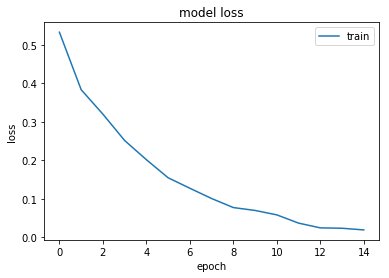

In [17]:
history.history.keys()
plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [15]:
sequences = tokenizer.texts_to_sequences(xtest)
data2=pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
model2 = Model(sequence_input, preds)
testpred=model2.predict(data2)

In [16]:
#for submission, the index column needs id as header.
df=pd.DataFrame()
df['realDonaldTrump']=testpred[:,1]
df['HillaryClinton']=testpred[:,0]
writer = pd.ExcelWriter('pandas_simple.xlsx')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()